# CMB lensing and cross correlations using CCL

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import camb

In [2]:
print(ccl.__version__)

3.0.0


In [3]:
import os, sys

### CCL cosmology

In [4]:
h = 0.67
Omega_c = 0.27
Omega_b = 0.045
A_s = 2.1e-9
n_s = 0.96
tau = 0.06
mnu = 0.
matter_power_spectrum = "halofit"

# Default CAMB halofit params
halofit_version = "mead2020"
HMCode_A_baryon=3.13
HMCode_eta_baryon=0.603
HMCode_logT_AGN=7.8

cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, A_s=A_s, n_s=n_s, m_nu = mnu,
                      transfer_function='boltzmann_camb', matter_power_spectrum=matter_power_spectrum,
                     extra_parameters={"camb": {"tau":tau, "halofit_version":halofit_version, 
                                               "HMCode_A_baryon":HMCode_A_baryon, "HMCode_eta_baryon":HMCode_eta_baryon,
                                               "HMCode_logT_AGN":HMCode_logT_AGN}})

### Camb cosmology

In [5]:
pars = camb.CAMBparams()

pars.set_cosmology(H0=h*100, ombh2=Omega_b* h**2, omch2=Omega_c * h**2, mnu=mnu, omk=0, tau=tau)
pars.InitPower.set_params(As=A_s, ns=n_s, r=0)

pars.NonLinearModel.set_params(
    halofit_version=halofit_version,
    HMCode_A_baryon=HMCode_A_baryon,
    HMCode_eta_baryon=HMCode_eta_baryon,
    HMCode_logT_AGN=HMCode_logT_AGN,
)

pars.set_for_lmax(2500, lens_potential_accuracy=8);


In [6]:
#calculate results for these parameters
camb_results = camb.get_results(pars)

### Angular correlation function of galaxies with CCL

Define a sample of galaxies via a redshift distribution for the galaxies and bias (=1.5 - constant in this example)


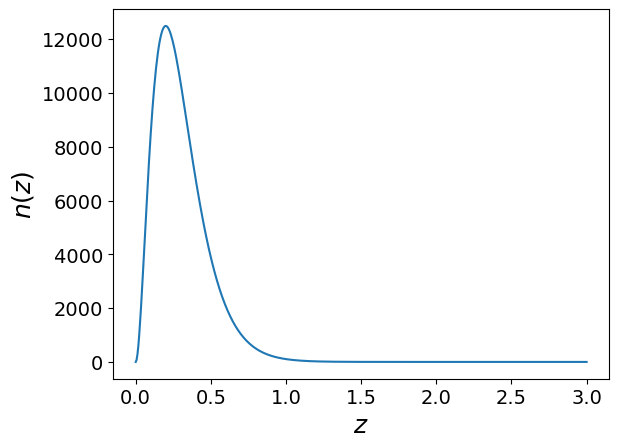

In [7]:
z = np.linspace(0., 3., 512)
i_lim = 26. # Limiting i-band magnitude
#z0 = 0.0417*i_lim - 0.744
z0=0.1

Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution
b = 1.5*np.ones(512) #Galaxy bias (constant with scale and z)

plt.xlabel('$z$',fontsize=18)
plt.ylabel('$n(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(z, dNdz)
plt.show()

Create tracers of DM - galaxies - no RSD

In [8]:
galaxies = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))


Calculating auto (same redshift bin) galaxy angular power spectrum

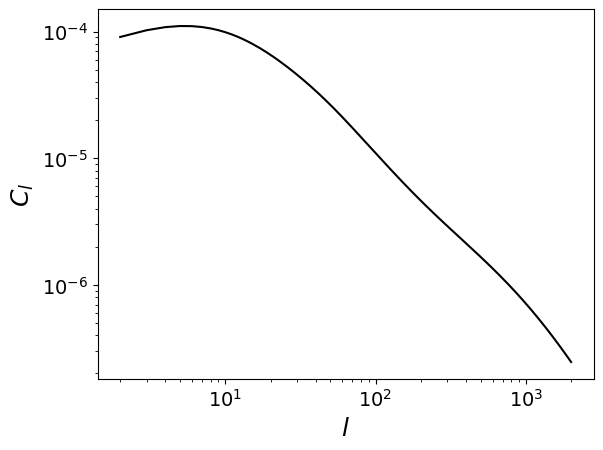

In [9]:
ell = np.arange(2, 2000)

cls_gal = ccl.angular_cl(cosmo, galaxies, galaxies, ell) #Clustering

plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C_l$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_gal, 'k-')
plt.show()

## CMB lensing power spectrum

Note for comparing CCL and CAMB results:
- CCL returns the lensing convergence $\kappa$
- CAMB returns the lensing potential $\phi$ (when raw_cl = True)

$$
C_{L}^{\kappa \kappa} =  \frac{(\ell (\ell+1))^2 } {4} C_{L}^{\phi \phi}
$$

In [10]:
def pp2kk(ell):
    return (ell*(ell+1))**2 / 4

CMB lensing tracer from CCL

In [11]:
# z_source should be computed from the cosmology 
results= camb.get_background(pars)
chistar = results.conformal_time(0)- results.tau_maxvis
# chis = np.linspace(0,chistar,nz)
zs=results.redshift_at_comoving_radial_distance(chistar)
print(zs)

1091.829047621115


In [12]:
cmbk = ccl.CMBLensingTracer(cosmo, z_source=zs, n_samples=1000)

Auto power spectrum of CMB lensing

In [13]:
cls_kcmb = ccl.angular_cl(cosmo, cmbk, cmbk, ell)
camb_cls_kcmb = camb_results.get_lens_potential_cls(lmax=2000, raw_cl = True)[:, 0] * pp2kk(np.arange(2001))


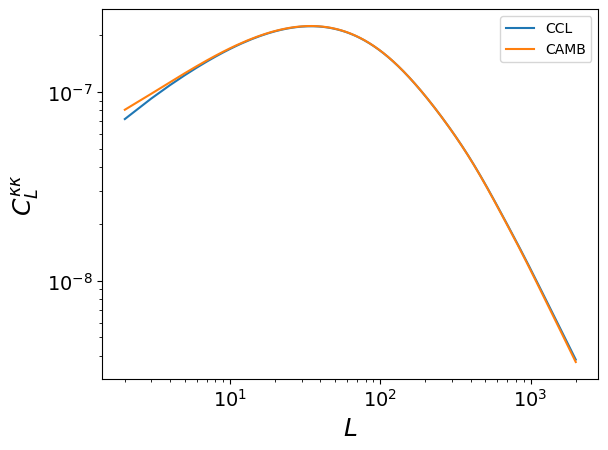

In [14]:

plt.xlabel('$L$',fontsize=18)
plt.ylabel('$C_L^{\kappa \kappa}$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')


plt.plot(ell, cls_kcmb, label='CCL')
plt.plot(ell, camb_cls_kcmb[ell], label='CAMB')


plt.legend()



Comparing CAMB and CCL spectra

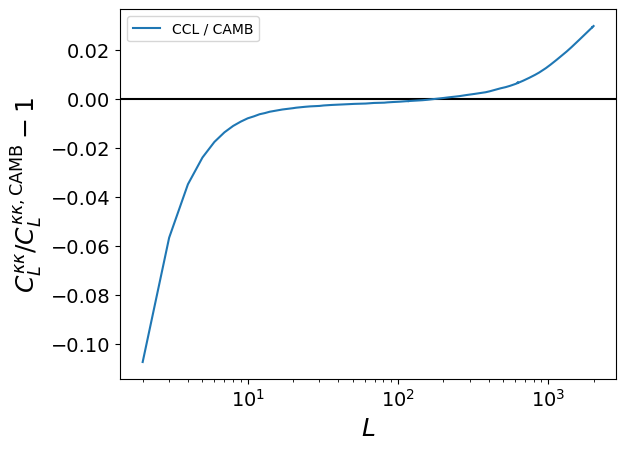

In [16]:
plt.axhline(y=0, c='k')

plt.plot(ell, cls_kcmb / camb_cls_kcmb[ell] -1 , label='CCL / CAMB')

plt.semilogx()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('$C_L^{\kappa \kappa} / C_L^{\kappa \kappa, \mathrm{CAMB}} - 1$', fontsize=18)
plt.xlabel('$L$', fontsize=18)

plt.legend()

The difference at low L (L<10) is due to the Limber approximation. 
It seems that the non-Limber integration is not implemented yet in CCL.

The High-ell difference might be some specific settings in the Halofit algorithm.

### Cross correlation between galaxies and CMB lensing

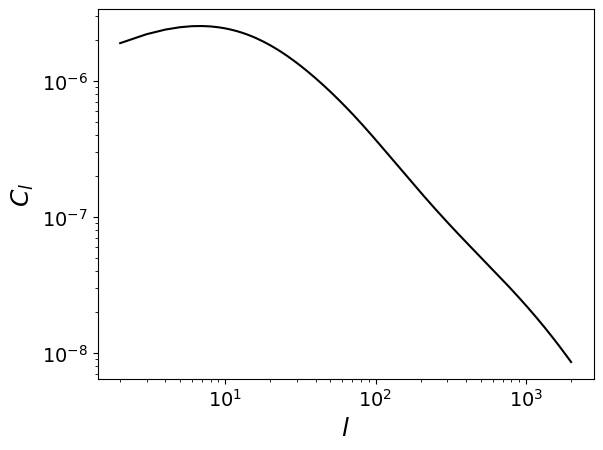

In [17]:
cls_gal_kcmb = ccl.angular_cl(cosmo, galaxies, cmbk, ell)

plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C_l$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_gal_kcmb, 'k-')
plt.show()